# Simple Test for Hierarchical ABI with compositional score matching

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from bayesflow import diagnostics
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
torch_device = torch.device("cpu")
torch_device

device(type='cpu')

In [4]:
# eight schools problem
J = 8
y = np.array([28., 8, -3, 7, -1, 1, 18, 12])[:, np.newaxis]  # our groups, one observation per group
#y = np.repeat(y[:, np.newaxis].T, 2, axis=0).flatten()
sigma = np.array([15., 10, 16, 11, 9, 11, 10, 18])  # assumed to be known
#sigma = np.repeat(sigma[:, np.newaxis].T, 2, axis=0).flatten()  # sigma is known, so part of the observation
n_obs_per_group = 2  # sigma is known, so part of the observation

In [5]:
# simulator example
def simulator(params, school_i=None):
    batch_size = params['theta_j'].shape[0]
    y_j = np.random.normal(loc=params['theta_j'], scale=sigma, size=(batch_size, J))
    if school_i is None:
        return dict(observable=y_j, sigma=np.tile(sigma, (batch_size, 1)))
    return dict(observable=y_j[:, school_i][:, np.newaxis], sigma=(np.ones(batch_size)*sigma[school_i])[:, np.newaxis])


class Prior:
    def __init__(self):
        self.mu_mean = 0
        self.mu_std = 3
        self.log_tau_mean = 3
        self.log_tau_std = 1

        np.random.seed(0)
        test_prior = self.sample(1000)
        test = simulator(test_prior, school_i=None)
        self.x_mean = torch.tensor(np.array([np.mean(test['observable']), np.mean(test['sigma'])]),
                                   dtype=torch.float32, device=torch_device)
        self.x_std = torch.tensor(np.array([np.std(test['observable']), np.std(test['sigma'])]),
                                  dtype=torch.float32, device=torch_device)
        self.prior_global_mean = torch.tensor(np.array([np.mean(test_prior['mu']), np.mean(test_prior['log_tau'])]),
                                              dtype=torch.float32, device=torch_device)
        self.prior_global_std = torch.tensor(np.array([np.std(test_prior['mu']), np.std(test_prior['log_tau'])]),
                                             dtype=torch.float32, device=torch_device)
        self.prior_local_mean = torch.tensor(np.array([np.mean(test_prior['theta_j'])]),
                                             dtype=torch.float32, device=torch_device)
        self.prior_local_std = torch.tensor(np.array([np.std(test_prior['theta_j'])]),
                                            dtype=torch.float32, device=torch_device)

    def __call__(self, batch_size):
        return self.sample(batch_size)

    def sample(self, batch_size):
        mu = np.random.normal(loc=self.mu_mean, scale=self.mu_std, size=(batch_size,1))
        log_tau = np.random.normal(loc=self.log_tau_mean, scale=self.log_tau_std, size=(batch_size,1))
        theta_j = np.random.normal(loc=mu, scale=np.exp(log_tau), size=(batch_size, J))
        return dict(mu=mu, log_tau=log_tau, theta_j=theta_j)

    def score_global_batch(self, theta_batch_norm, condition_norm=None):
        """ Computes the global score for a batch of parameters."""
        theta_batch = theta_batch_norm * self.prior_global_std + self.prior_global_mean
        mu, log_tau = theta_batch[..., 0], theta_batch[..., 1]
        grad_logp_mu = -(mu - self.mu_mean) / (self.mu_std**2)
        grad_logp_tau = -(log_tau - self.log_tau_mean) / (self.log_tau_std**2)
        # correct the score for the normalization
        score = torch.stack([grad_logp_mu, grad_logp_tau], dim=-1)
        return score / self.prior_global_std

    def score_local_batch(self, theta_batch_norm, condition_norm):
        """ Computes the local score for a batch of samples. """
        theta_j = theta_batch_norm * self.prior_local_std + self.prior_local_mean
        condition = condition_norm * self.prior_global_std + self.prior_global_mean
        mu, log_tau = condition[..., 0], condition[..., 1]
        # Gradient w.r.t theta_j conditioned on mu and log_tau
        grad_logp_theta_j = -(theta_j - mu) / torch.exp(log_tau*2)
        # correct the score for the normalization
        score = grad_logp_theta_j / self.prior_local_std
        return score

prior = Prior()
n_params_global = 2
n_params_local = 1

In [6]:
prior(2)

{'mu': array([[0.01804263],
        [2.25831363]]),
 'log_tau': array([[3.23244057],
        [3.59150044]]),
 'theta_j': array([[-25.85921258,   3.73865364,  25.2270058 ,  -2.90502784,
         -55.83154007,  -9.26848128,  21.05281689,  19.12717564],
        [-41.6764881 ,  11.91721566,  51.26940354,  72.64061604,
          -4.72118599, -18.78513876,  42.4954885 , -18.52549993]])}

In [7]:
simulator(prior(2))

{'observable': array([[-26.48444098,   1.20916944, -44.3941905 ,   1.42804338,
          -7.11516752,  -8.64472688,  10.01806406,  -8.87862201],
        [ 43.81419677,   3.35250855, -42.67924985, -25.86143932,
          -8.06856768, -22.78203838,  -2.17169145, -68.92214661]]),
 'sigma': array([[15., 10., 16., 11.,  9., 11., 10., 18.],
        [15., 10., 16., 11.,  9., 11., 10., 18.]])}

In [83]:
def positional_encoding(t, d_model, max_t=1000.0):  # todo: before 10000
    """
    Computes the sinusoidal positional encoding for a given time t.

    Args:
        t (torch.Tensor): The input time tensor of shape (batch_size, 1).
        d_model (int): The dimensionality of the embedding.

    Returns:
        torch.Tensor: The positional encoding of shape (batch_size, d_model).
    """
    half_dim = d_model // 2
    div_term = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=t.device) *
                         -(math.log(max_t) / (half_dim - 1)))
    t_proj = t * div_term
    pos_enc = torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)
    return pos_enc

# Define the Score Model
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.norm = nn.LayerNorm(out_features)
        self.activation = nn.SiLU()  # same as swish
        self.dropout = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    @staticmethod
    def swish(x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        identity = self.proj(x)
        out = self.linear(x)
        out = self.norm(out)
        out = self.activation(out)
        out = self.dropout(out)
        return out + identity

class ConditionalResidualBlock(nn.Module):
    def __init__(self, hidden_dim, cond_dim, dropout=0.1):
        super(ConditionalResidualBlock, self).__init__()
        # First linear layer that takes [hidden state; conditioning]
        self.fc1 = nn.Linear(hidden_dim + cond_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        # Second linear layer also takes [hidden state; conditioning]
        self.fc2 = nn.Linear(hidden_dim + cond_dim, hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.activation = nn.SiLU()  # same as swish
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def swish(x):
        return x * torch.sigmoid(x)

    def forward(self, h, cond):
        # Concatenate the hidden state with the conditioning vector
        x = torch.cat([h, cond], dim=-1)
        out = self.fc1(x)
        out = self.norm1(out)
        out = self.activation(out)
        out = self.dropout(out)
        # Inject conditioning again before the second transformation
        out = self.fc2(torch.cat([out, cond], dim=-1))
        out = self.norm2(out)
        # Add the original hidden state (skip connection) and apply activation
        return self.activation(out + h)

class ScoreModel(nn.Module):
    """
        Neural network model that computes score estimates.

        Args:
            input_dim_theta (int): Input dimension for theta.
            input_dim_x (int): Input dimension for x.
            input_dim_condition (int): Input dimension for the condition. Can be 0 for global score.
            hidden_dim (int): Hidden dimension for theta network.
            time_embed_dim (int, optional): Dimension of time embedding. Defaults to 4.
    """
    def __init__(self,
                 input_dim_theta, input_dim_x, input_dim_condition,
                 hidden_dim,
                 time_embed_dim=16):
        super(ScoreModel, self).__init__()
        self.time_embed_dim = time_embed_dim

        # Define the dimension of the conditioning vector
        cond_dim = input_dim_x + input_dim_condition + time_embed_dim
        self.cond_dim = cond_dim

        # Project the concatenation of theta and the condition into hidden_dim
        self.input_layer = nn.Linear(input_dim_theta + cond_dim, hidden_dim)

        # Create a sequence of conditional residual blocks
        self.block1 = ConditionalResidualBlock(hidden_dim, cond_dim)
        self.block2 = ConditionalResidualBlock(hidden_dim, cond_dim)
        self.block3 = ConditionalResidualBlock(hidden_dim, cond_dim)

        # Create a sequence of residual blocks
        #self.block1 = ResidualBlock(input_dim_theta + cond_dim, hidden_dim)
        #self.block2 = ResidualBlock(hidden_dim, hidden_dim)
        #self.block3 = ResidualBlock(hidden_dim, hidden_dim)

        # Final layer to get back to the theta dimension
        self.final_linear = nn.Linear(hidden_dim, input_dim_theta)

    def forward(self, theta, t, x, conditions=None):
        """
        Forward pass of the ScoreModel.

        Args:
            theta (torch.Tensor): Input theta tensor of shape (batch_size, input_dim_theta).
            t (torch.Tensor): Input time tensor of shape (batch_size, 1).
            x (torch.Tensor): Input x tensor of shape (batch_size, input_dim_x).
            conditions (torch.Tensor, optional): Input condition tensor of shape (batch_size, input_dim_condition).
                Defaults to None.

        Returns:
            torch.Tensor: Output of the score model.
        """
        # Compute a time embedding (shape: [batch, time_embed_dim])
        t_emb = positional_encoding(t, self.time_embed_dim)

        # Form the conditioning vector. If conditions is None, only x and time are used.
        if conditions is not None:
            cond = torch.cat([x, conditions, t_emb], dim=-1)
        else:
            cond = torch.cat([x, t_emb], dim=-1)

        # Concatenate theta with the conditioning vector as the initial input
        h = torch.cat([theta, cond], dim=-1)
        h = self.input_layer(h)

        # Pass through each residual block, injecting the same cond at each layer
        h = self.block1(h, cond)
        h = self.block2(h, cond)
        h = self.block3(h, cond)

        theta_emb = self.final_linear(h)
        return theta_emb


class HierarchicalScoreModel(nn.Module):
    def __init__(self,
                 input_dim_theta_local, input_dim_theta_global, input_dim_x,
                 hidden_dim,
                 time_embed_dim=16):
        super(HierarchicalScoreModel, self).__init__()
        self.n_params_global = input_dim_theta_global
        self.global_model = ScoreModel(
            input_dim_theta=input_dim_theta_global,
            input_dim_x=input_dim_x,
            input_dim_condition=0,
            hidden_dim=hidden_dim,
            time_embed_dim=time_embed_dim
        )
        self.n_params_local = input_dim_theta_local
        self.local_model = ScoreModel(
            input_dim_theta=input_dim_theta_local,
            input_dim_x=input_dim_x,
            input_dim_condition=input_dim_theta_global,
            hidden_dim=hidden_dim,
            time_embed_dim=time_embed_dim
        )

    def forward(self, theta, t, x):
        theta_global, theta_local = torch.split(theta, [self.n_params_global, self.n_params_local], dim=-1)
        global_out = self.global_model.forward(theta=theta_global, t=t, x=x, conditions=None)
        local_out = self.local_model.forward(theta=theta_local, t=t, x=x, conditions=theta_global)
        return torch.cat([global_out, local_out], dim=-1)

    def forward_local(self, theta_local, theta_global, t, x):
        local_out = self.local_model.forward(theta=theta_local, t=t, x=x, conditions=theta_global)
        return local_out

    def forward_global(self, theta_global, t, x):
        global_out = self.global_model.forward(theta=theta_global, t=t, x=x, conditions=None)
        return global_out

In [84]:
def generate_synthetic_data(n_samples, schools_joint=False, device=None):
    params_global = []
    params_local = []
    data = []
    for i in range(n_samples):
        batch_params = prior(1)
        if schools_joint:
            sim_batch = simulator(batch_params)
            param_global = torch.tensor(np.concatenate([batch_params['mu'], batch_params['log_tau']], axis=-1),
                                         dtype=torch.float32, device=device)
            param_local = torch.tensor(batch_params['theta_j'], dtype=torch.float32, device=device)
            x = torch.tensor(np.stack((sim_batch['observable'], sim_batch['sigma']), axis=-1),
                             dtype=torch.float32, device=device)
        else:
            sim_batch = simulator(batch_params, school_i=i % J)
            param_global = torch.tensor(np.concatenate([batch_params['mu'], batch_params['log_tau']], axis=-1),
                                         dtype=torch.float32, device=device)
            param_local = torch.tensor(batch_params['theta_j'][:, i % J][:, np.newaxis], dtype=torch.float32, device=device)
            x = torch.tensor(np.concatenate((sim_batch['observable'], sim_batch['sigma']), axis=-1),
                             dtype=torch.float32, device=device)

        params_global.append(param_global)
        params_local.append(param_local)
        data.append(x)
    param_global = torch.concatenate(params_global)
    param_local = torch.concatenate(params_local)
    data = torch.concatenate(data)
    return param_global, param_local, data

In [85]:
def cosine_schedule_diffusion_time(t, max_t, s=0.008):
    return torch.cos(((t/max_t + s) / (1 + s)) * (np.pi / 2)) ** 2

def generate_diffusion_time(max_t, steps, random=False, device=None):
    """variance based on the Improved Denoising Diffusion Probabilistic Models paper"""
    if random:
        time = torch.rand(steps+1, dtype=torch.float32, device=device) * max_t
        time = torch.sort(time)[0]
    else:
        time = torch.linspace(0, max_t, steps+1, dtype=torch.float32, device=device)

    # gamma called alpha_t in paper
    f_0 = 1#cosine_schedule_diffusion_time(torch.tensor(0, dtype=torch.float32, device=device), max_t)
    gamma = cosine_schedule_diffusion_time(time, max_t) / f_0
    beta_t = 1 - torch.cat((gamma[0:1], gamma[1:] / gamma[:-1]), dim=0)
    # clip to avoid numerical instability
    beta_t = torch.clamp(beta_t, max=0.999)
    return time, gamma, beta_t

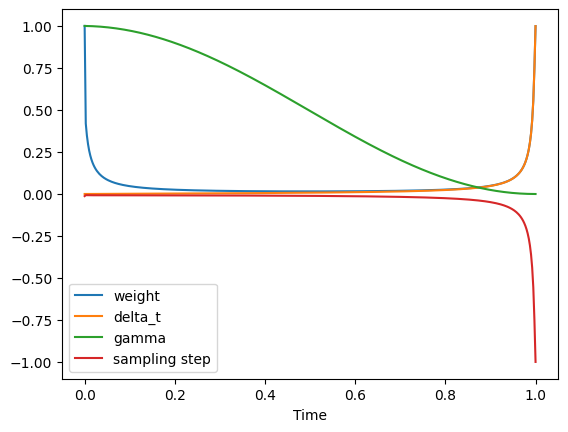

In [86]:
time, gamma, delta_t = generate_diffusion_time(400, 400)

plt.plot(time / 400, delta_t / (1-gamma), label='weight')
plt.plot(time / 400, delta_t, label='delta_t')
plt.plot(time / 400, gamma, label='gamma')
plt.plot(time / 400, -1 / torch.sqrt(1 - gamma) * delta_t, label='sampling step')
#plt.plot(time, torch.linspace(1, 0, 400+1, dtype=torch.float32)[1:-1], label='gamma_lin')
plt.xlabel('Time')
plt.legend()
plt.show()

In [87]:
 # Loss function for weighted MSE
def weighted_mse_loss(inputs, targets, weights):
    return torch.mean(weights * (inputs - targets) ** 2)


def compute_score_loss(x_batch, theta_prime_batch, model, diffusion_time, gamma, delta_t, device=None):
    # sample a diffusion time for each sample in the batch
    t_index = torch.randint(0, len(diffusion_time), size=(x_batch.shape[0],), device=device)
    t = diffusion_time[t_index]
    g = gamma[t_index]
    w = delta_t[t_index]
    # sample from the Gaussian kernel, just learn the noise
    epsilon = torch.randn_like(theta_prime_batch, dtype=torch.float32, device=device)
    theta_batch = torch.sqrt(g) * theta_prime_batch + torch.sqrt(1 - g) * epsilon
    # calculate the score for the sampled theta
    score_pred = model(theta=theta_batch, t=t, x=x_batch)
    # calculate the loss
    loss = weighted_mse_loss(score_pred, epsilon, weights=w / (1 - g))
    return loss


# Training loop for Score Model
def train_score_model(model, dataloader, dataloader_valid=None,
                      T=400, epochs=100, lr=1e-3, steps_diffusion_time=400, device=None):
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Add Cosine Annealing Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # Generate diffusion time and step size
    diffusion_time, gamma, delta_t = generate_diffusion_time(max_t=T, steps=steps_diffusion_time, device=device)

    # Add a new dimension so that each tensor has shape (steps, 1)
    diffusion_time = diffusion_time.unsqueeze(1)
    gamma = gamma.unsqueeze(1)
    delta_t = delta_t.unsqueeze(1)

    # Training loop
    loss_history = np.zeros((epochs, 2))
    for epoch in range(epochs):
        total_loss = []
        # for each sample in the batch, calculate the loss for a random diffusion time
        for theta_global_prime_batch, theta_local_prime_batch, x_batch in dataloader:
            # initialize the gradients
            optimizer.zero_grad()
            theta_prime_batch = torch.concat([theta_global_prime_batch, theta_local_prime_batch], dim=-1)
            # calculate the loss
            loss = compute_score_loss(x_batch=x_batch, theta_prime_batch=theta_prime_batch,
                                      model=model, diffusion_time=diffusion_time, gamma=gamma, delta_t=delta_t, device=device)
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optimizer.step()
            total_loss.append(loss.item())

        scheduler.step()

        # validate the model
        valid_loss = []
        if dataloader_valid is not None:
            for theta_global_prime_batch, theta_local_prime_batch, x_batch in dataloader_valid:
                with torch.no_grad():
                    theta_prime_batch = torch.concat([theta_global_prime_batch, theta_local_prime_batch], dim=-1)
                    loss = compute_score_loss(x_batch, theta_prime_batch=theta_prime_batch,
                                              model=model, diffusion_time=diffusion_time, gamma=gamma, delta_t=delta_t, device=device)
                    valid_loss.append(loss.item())

        loss_history[epoch] = [np.median(total_loss), np.median(valid_loss)]
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.median(total_loss):.4f}, "
              f"Valid Loss: {np.median(valid_loss):.4f}", end='\r')
    return loss_history

In [88]:
# Hyperparameters
n_samples = 50000
batch_size = 256
T = 400
steps_time = T

score_model = HierarchicalScoreModel(
    input_dim_theta_global=n_params_global,
    input_dim_theta_local=n_params_local,
    input_dim_x=n_obs_per_group,
    hidden_dim=64
)
score_model.to(torch_device)


# Create model and dataset
thetas_global, thetas_local, xs = generate_synthetic_data(n_samples, schools_joint=False, device=torch_device)  # todo: False
# Normalize data
thetas_global = (thetas_global - prior.prior_global_mean) / prior.prior_global_std
thetas_local = (thetas_local - prior.prior_local_mean) / prior.prior_local_std
xs = (xs - prior.x_mean) / prior.x_std
#xs = xs.reshape(-1, n_obs_per_group*J)  # todo

# Create dataloader
dataset = TensorDataset(thetas_global, thetas_local, xs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# create validation data
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(1000, schools_joint=False, device=torch_device)  # todo: False
valid_data = (valid_data - prior.x_mean) / prior.x_std
#valid_data = valid_data.reshape(-1, n_obs_per_group*J)  # todo
valid_prior_global = (valid_prior_global - prior.prior_global_mean) / prior.prior_global_std
valid_prior_local = (valid_prior_local - prior.prior_local_mean) / prior.prior_local_std
dataset_valid = TensorDataset(valid_prior_global, valid_prior_local, valid_data)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size)

In [89]:
# Train model
score_model.train()
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 T=T, epochs=100, lr=1e-3, steps_diffusion_time=steps_time,
                                 device=torch_device)
score_model.eval();

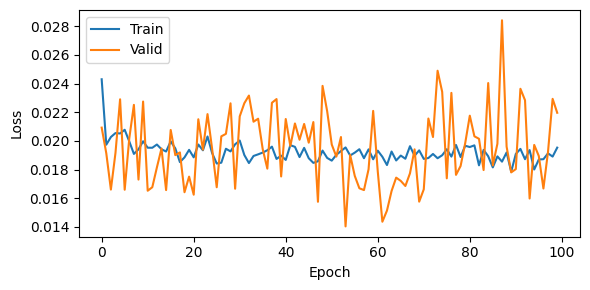

In [90]:
# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Train')
plt.plot(loss_history[:, 1], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [106]:
# Annealed Langevin Dynamics for Sampling
def langevin_sampling(model, x_obs, n_post_samples, conditions=None, steps=5, device=None):
    x_obs_norm = (x_obs - prior.x_mean) / prior.x_std  # assumes x_obs is not standardized
    #x_obs_norm = x_obs_norm.reshape(-1, n_obs_per_group*J)  # todo
    n_obs = x_obs_norm.shape[0]

    # Ensure x_obs_norm is a PyTorch tensor
    if not isinstance(x_obs_norm, torch.Tensor):
        x_obs_norm = torch.tensor(x_obs_norm, dtype=torch.float32, device=device)

    # Initialize parameters
    if conditions is None:  # global
        n_params = n_params_global
        theta = torch.randn(n_post_samples, n_params_global, dtype=torch.float32, device=device) / torch.sqrt(torch.tensor(n_obs, dtype=torch.float32, device=device)) # todo:
        conditions_exp = None
    else:
        # Ensure conditions is a PyTorch tensor
        if not isinstance(conditions, torch.Tensor):
            conditions = torch.tensor(conditions, dtype=torch.float32, device=device)

        n_params = n_params_local*n_obs
        theta = torch.randn(n_post_samples, n_obs, n_params_local, dtype=torch.float32, device=device)
        conditions = (conditions - prior.prior_global_mean) / prior.prior_global_std
        conditions_exp = conditions.unsqueeze(0).expand(n_post_samples, n_obs, -1).reshape(-1, n_params_global)

    # Generate diffusion time parameters
    diffusion_time, gamma, delta_t = generate_diffusion_time(max_t=T, steps=steps_time, device=device)
    scaling = -1 / torch.sqrt(1 - gamma)



    # Expand x_obs_norm to match the number of posterior samples
    x_exp = x_obs_norm.unsqueeze(0).expand(n_post_samples, -1, -1)  # Shape: (n_post_samples, n_obs, d)
    x_expanded = x_exp.reshape(-1, x_obs_norm.shape[-1])

    # Reverse iterate over diffusion times and step sizes
    for step_size, t, scale in tqdm(zip(delta_t.flip(0), diffusion_time.flip(0), scaling.flip(0)), total=steps_time+1):
        # Create tensor for current time step
        t_tensor = torch.full((n_post_samples, 1), t, dtype=torch.float32, device=device)
        t_exp = t_tensor.unsqueeze(1).expand(-1, n_obs, -1).reshape(-1, 1)

        for _ in range(steps):
            # Sample Gaussian noise
            eps = torch.randn_like(theta, dtype=torch.float32, device=device)

            if conditions is None:  # todo: global
                # Compute prior score
                prior_score = prior.score_global_batch(theta)
            else:
                prior_score = 0

            # Compute model scores
            if conditions is None:
                theta_exp = theta.unsqueeze(1).expand(-1, n_obs, -1).reshape(-1, n_params_global)
                model_scores = model.forward_global(theta_global=theta_exp, t=t_exp, x=x_expanded)
                # Sum over observations
                model_scores = model_scores.reshape(n_post_samples, n_obs, -1).sum(dim=1)  # todo
                #print(model_scores.shape, theta_exp.shape, theta.shape)
            else:
                theta_exp = theta.reshape(-1, n_params_local)
                model_scores = model.forward_local(theta_local=theta_exp, t=t_exp, x=x_expanded, theta_global=conditions_exp)
                model_scores = model_scores.reshape(n_post_samples, n_obs, -1)

            # Compute updated scores and perform Langevin step
            # scaling since we learned the scaled score network (noise)
            scores = (1 - n_obs) * (T - t) / T * prior_score + scale * model_scores
            theta = theta + (step_size / 2) * scores + torch.sqrt(step_size) * eps
        if torch.isnan(theta).any():
            print("NaNs in theta")
            break
    # correct for normalization
    if conditions is None:
        theta = theta * prior.prior_global_std + prior.prior_global_mean
    else:
        theta = theta * prior.prior_local_std + prior.prior_local_mean
    # convert to numpy
    theta = theta.detach().numpy().reshape(n_post_samples, n_params)
    return theta

# Validation

In [98]:
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(10, schools_joint=True, device=torch_device)

In [101]:
posterior_global_samples_valid = np.array([langevin_sampling(score_model, vd, n_post_samples=100, steps=1,
                                                          device=torch_device)
                                        for vd in valid_data])

100%|██████████| 401/401 [00:03<00:00, 100.70it/s]


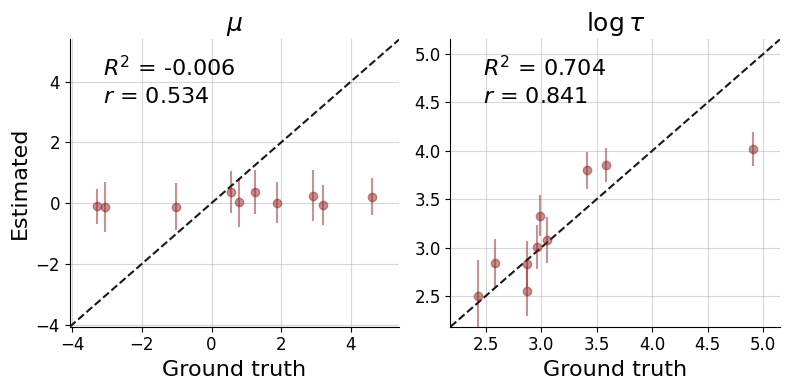

In [102]:
diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=[r'$\mu$', r'$\log \tau$']);

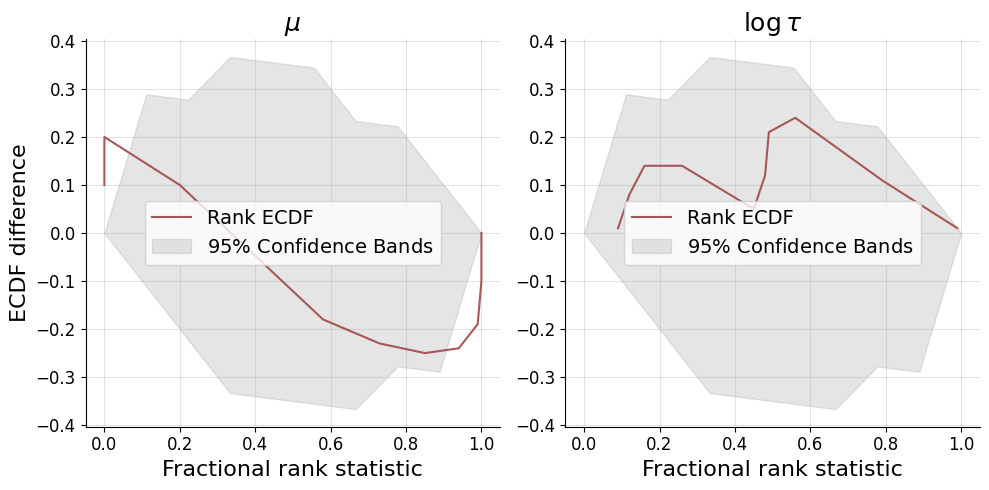

In [103]:
diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$']);

In [107]:
conditions_global = np.median(posterior_global_samples_valid, axis=0)
posterior_local_samples_valid = np.array([langevin_sampling(score_model, vd, n_post_samples=100, conditions=c, steps=1,
                                                          device=torch_device)
                                        for vd, c in zip(valid_data, conditions_global)])

100%|██████████| 401/401 [00:00<00:00, 557.92it/s]


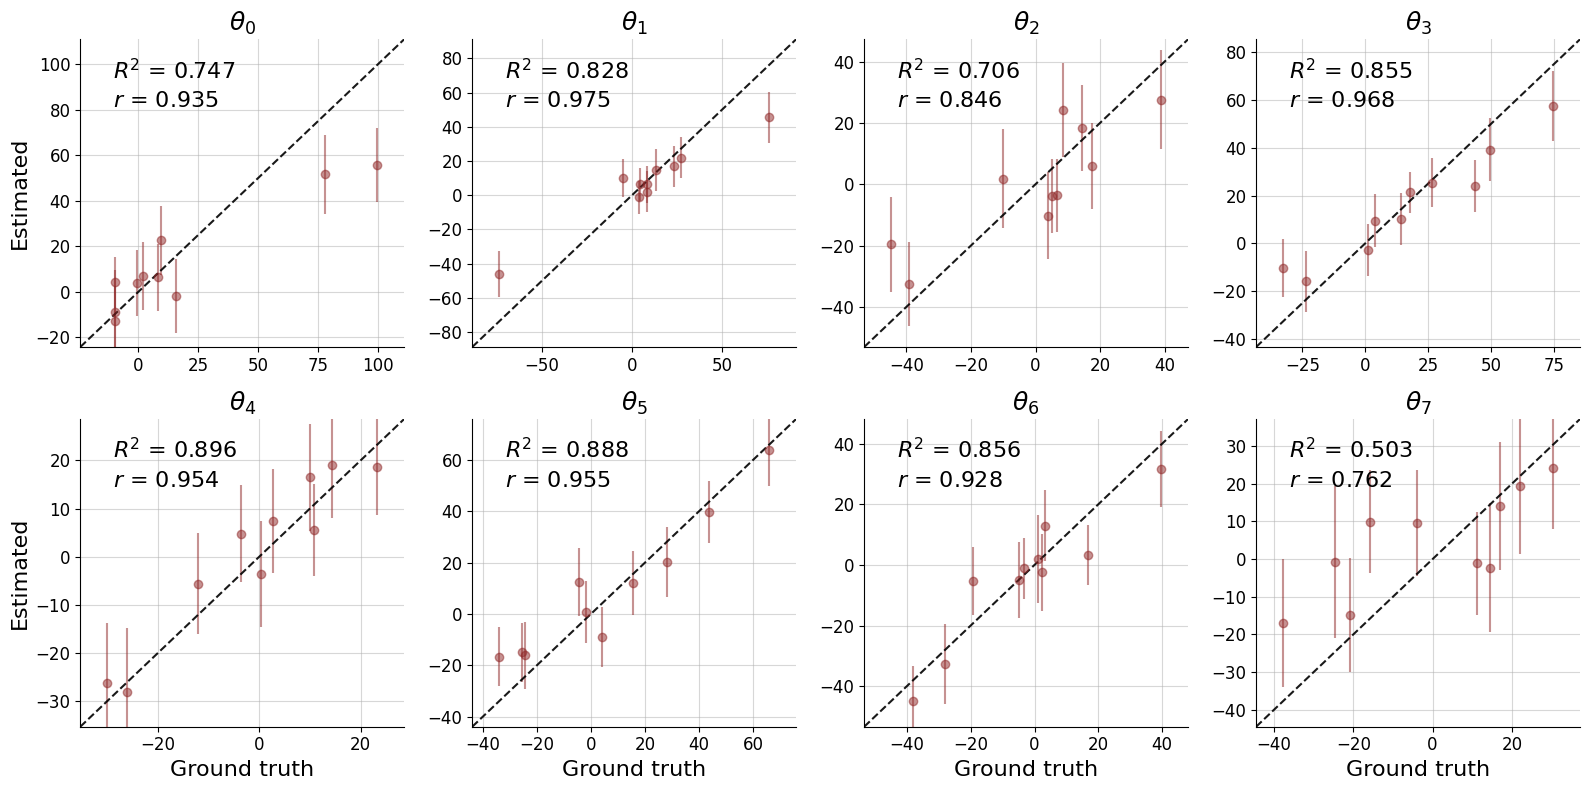

In [108]:
diagnostics.plot_recovery(posterior_local_samples_valid, np.array(valid_prior_local), param_names=[f'$\\theta_{i}$' for i in range(J)]);

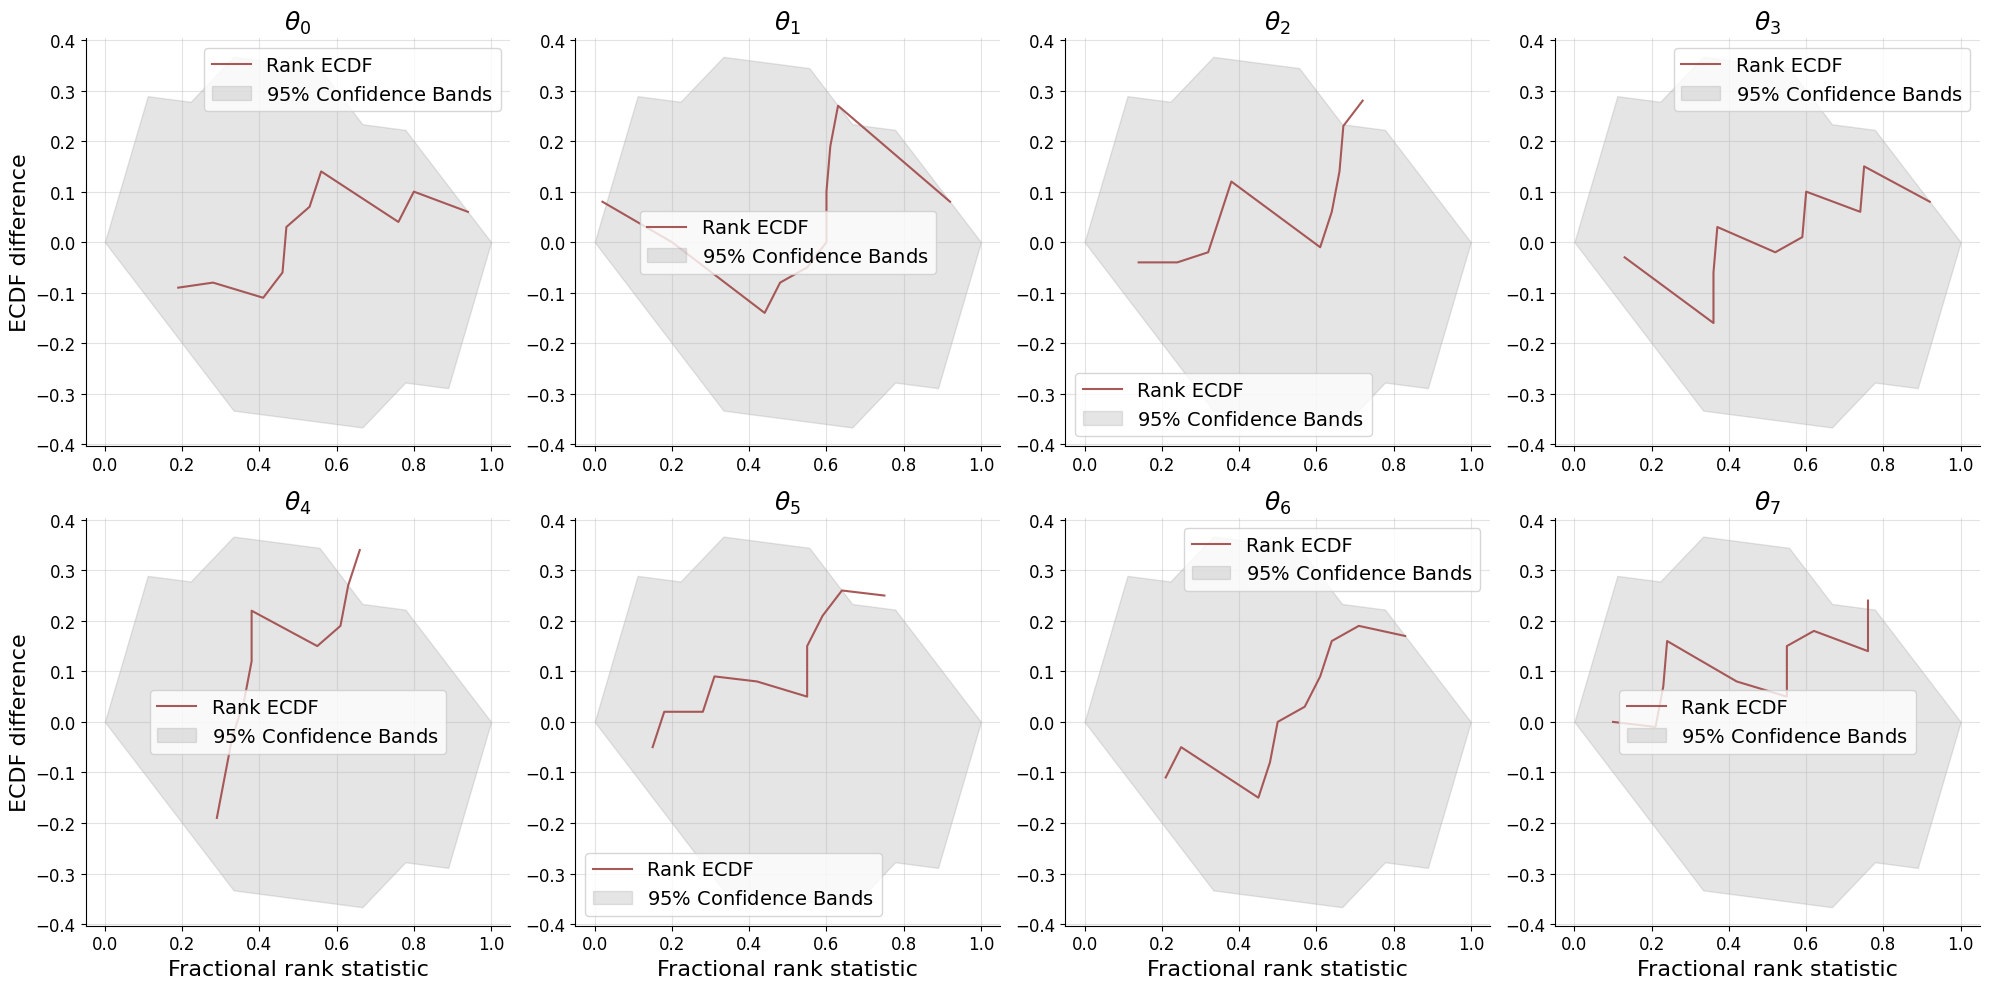

In [109]:
diagnostics.plot_sbc_ecdf(posterior_local_samples_valid, np.array(valid_prior_local),
                          difference=True, param_names=[f'$\\theta_{i}$' for i in range(J)]);

# Apply on Data

In [ ]:
# Generate posterior samples
test_data = torch.tensor(np.concatenate((y, sigma[:, np.newaxis]), axis=-1), dtype=torch.float32, device=torch_device)
if train_global:
    conditions = None
else:
    conditions = torch.tensor(np.array([6.78, 1.78]), dtype=torch.float32, device=torch_device)
posterior_samples = langevin_sampling(score_model, test_data, n_post_samples=valid_prior.shape[0], conditions=conditions)
print("Sampled posterior parameters:", posterior_samples)

In [ ]:
diagnostics.plot_posterior_2d(posterior_samples, prior_draws=valid_prior, param_names=param_names);

In [ ]:
if not train_global:
    school_effects_med = np.median(posterior_samples, axis=0)
    school_effects_low = np.percentile(posterior_samples, 2.5, axis=0)
    school_effects_hi = np.percentile(posterior_samples, 97.5, axis=0)
    avg_effect = conditions[0].item()

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6, 4))
    ax.scatter(np.array(range(J)), school_effects_med, color='red', s=60)
    ax.scatter(
        np.array(range(J)) + 0.1, y.flatten(), color='blue', s=60)

    plt.plot([-0.2, 7.4], [np.mean(avg_effect),
                           np.mean(avg_effect)], 'k', linestyle='--')

    ax.errorbar(
        np.array(range(8)),
        school_effects_med,
        yerr=[
            school_effects_med - school_effects_low,
            school_effects_hi - school_effects_med
        ],
        fmt='none')

    ax.legend(('ABI', 'Observed effect', 'avg_effect'), fontsize=14)

    plt.xlabel('School')
    plt.ylabel('Treatment effect')
    plt.title('ABI estimated school treatment effects vs. observed data')
    plt.show()

## HMC inference Results

https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb

In [110]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
#import seaborn as sns

In [111]:
def fit_hmc(data_y, data_sigma):
    model = tfd.JointDistributionSequential([
      tfd.Normal(loc=prior.mu_mean, scale=prior.mu_std, name="avg_effect"),  # `mu` above
      tfd.Normal(loc=prior.log_tau_mean, scale=prior.log_tau_std, name="avg_stddev"),  # `log(tau)` above
      tfd.Independent(tfd.Normal(loc=tf.zeros(J),
                                 scale=tf.ones(J),
                                 name="school_effects_standard"),  # `theta_prime`
                      reinterpreted_batch_ndims=1),
      lambda school_effects_standard, avg_stddev, avg_effect: (
          tfd.Independent(tfd.Normal(loc=(avg_effect[..., tf.newaxis] +
                                          tf.exp(avg_stddev[..., tf.newaxis]) *
                                          school_effects_standard),  # `theta` above
                                     scale=data_sigma.astype(np.float32)),
                          name="treatment_effects",  # `y` above
                          reinterpreted_batch_ndims=1))
    ])

    def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
      """Unnormalized target density as a function of states."""
      return model.log_prob((
          avg_effect, avg_stddev, school_effects_standard, data_y.flatten().astype(np.float32)))

    num_results = 5000
    num_burnin_steps = 3000

    # Improve performance by tracing the sampler using `tf.function`
    # and compiling it using XLA.
    @tf.function(autograph=False, jit_compile=True)
    def do_sampling():
      return tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=[
              tf.zeros([], name='init_avg_effect'),
              tf.zeros([], name='init_avg_stddev'),
              tf.ones([J], name='init_school_effects_standard'),
          ],
          kernel=tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=target_log_prob_fn,
              step_size=0.4,
              num_leapfrog_steps=3))

    states, kernel_results = do_sampling()

    avg_effect, avg_stddev, school_effects_standard = states

    school_effects_samples = (
        avg_effect[:, np.newaxis] +
        np.exp(avg_stddev)[:, np.newaxis] * school_effects_standard)

    num_accepted = np.sum(kernel_results.is_accepted)
    print('Acceptance rate: {}'.format(num_accepted / num_results))

    return avg_effect, avg_stddev, school_effects_standard, school_effects_samples

In [112]:
# repeat inference for validation data
posterior_samples_valid_hmc = []
for v in valid_data:
    v_temp = v.detach().numpy()
    avg_effect, avg_stddev, _, school_effects_samples = fit_hmc(v_temp[:, 0], v_temp[:, 1])
    posterior_samples_valid_hmc.append(np.concatenate((avg_effect[:, np.newaxis],
                                                       avg_stddev[:, np.newaxis],
                                                       school_effects_samples), axis=1))
posterior_samples_valid_hmc = np.array(posterior_samples_valid_hmc)

/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
I0000 00:00:1739570042.120219  272952 service.cc:148] XLA service 0x6000009b9900 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739570042.120538  272952 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-14 16:54:02.203242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-14 16:54:02.257955: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilati

Acceptance rate: 0.204
Acceptance rate: 0.0006


/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.2558


/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.0


/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.425


/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.0108
Acceptance rate: 0.3004


/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.0


/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.73


/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.3272


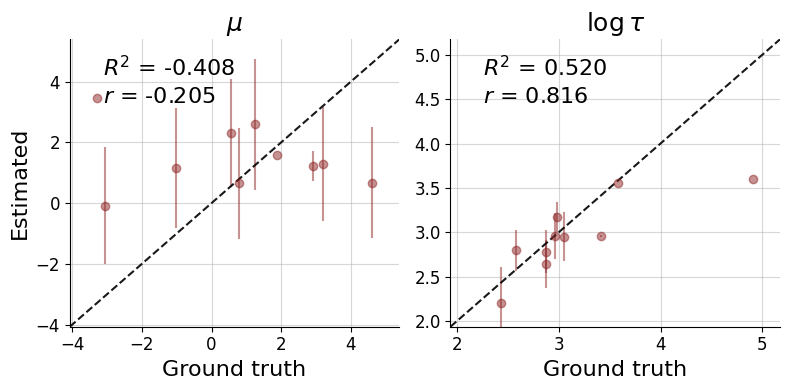

In [113]:
diagnostics.plot_recovery(posterior_samples_valid_hmc[:, :, :2], prior_samples=valid_prior_global,
                          param_names=[r'$\mu$', r'$\log \tau$']);

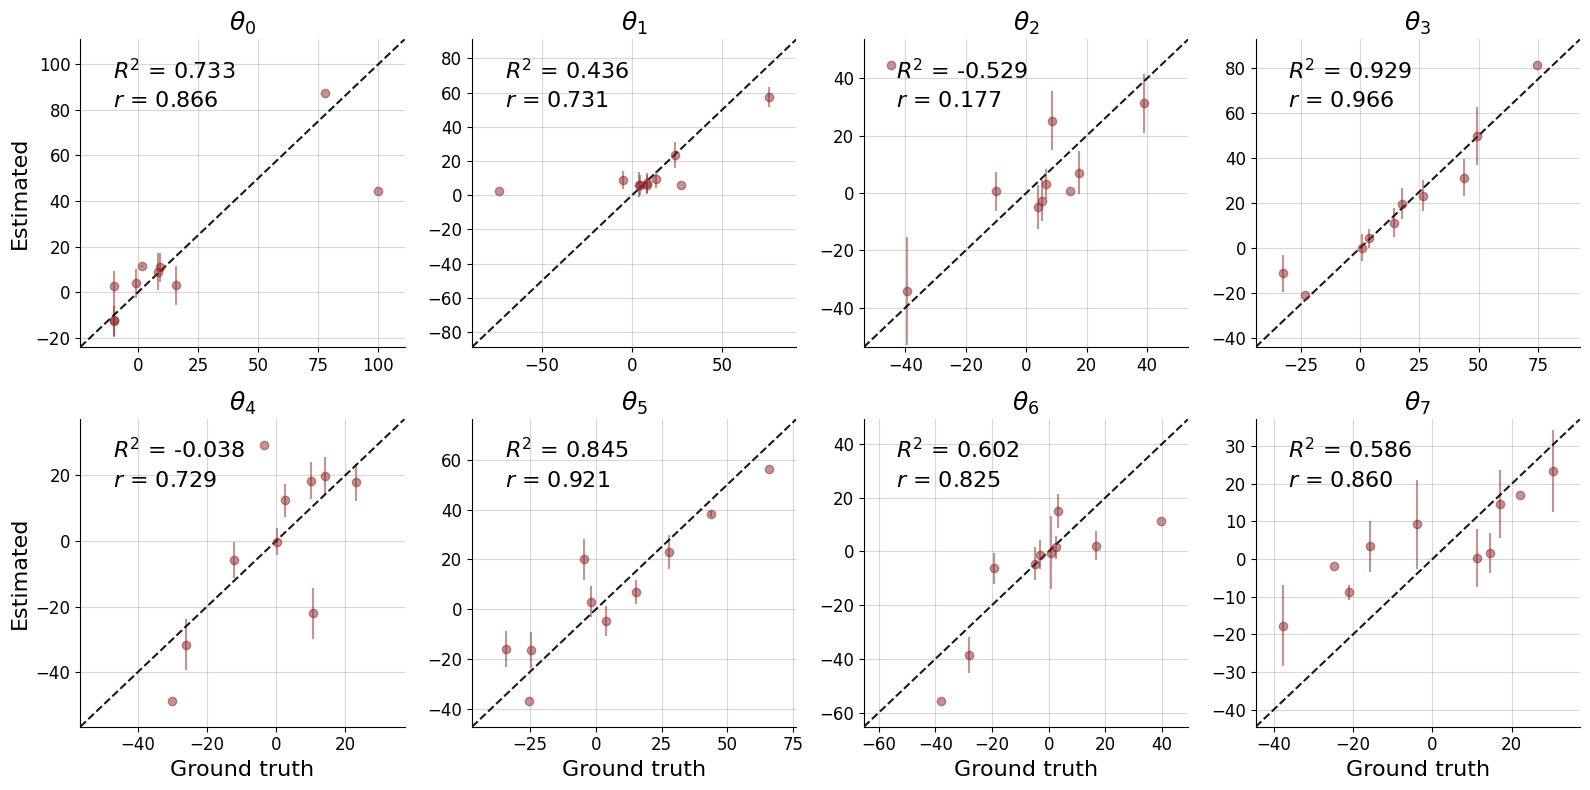

In [114]:
diagnostics.plot_recovery(posterior_samples_valid_hmc[:, :, 2:], prior_samples=valid_prior_local,
                              param_names=[f'$\\theta_{i}$' for i in range(J)]);

# Apply to Data

In [ ]:
avg_effect, avg_stddev, school_effects_standard, school_effects_samples = fit_hmc(y, sigma)

In [ ]:
param_names = [r'$\mu$', r'$\log \tau$']
valid_prior, _, _ = generate_synthetic_data(avg_effect.shape[0], schools_joint=True, device=torch_device)
diagnostics.plot_posterior_2d(tf.stack((avg_effect, avg_stddev), axis=1), prior_draws=valid_prior,
                              param_names=param_names);

In [ ]:
print("E[avg_effect] = {}".format(np.mean(avg_effect)))
print("E[avg_stddev] = {}".format(np.mean(avg_stddev)))
print("E[school_effects_standard] =")
print(np.mean(school_effects_standard[:, ]))
print("E[school_effects] =")
print(np.mean(school_effects_samples[:, ], axis=0))

In [ ]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(J)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(J)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(J)
])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6, 4))
ax.scatter(np.array(range(J)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(J)) + 0.1, y.flatten(), color='blue', s=60)

plt.plot([-0.2, 7.4], [np.mean(avg_effect),
                       np.mean(avg_effect)], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('HMC', 'Observed effect', 'avg_effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('HMC estimated school treatment effects vs. observed data')
plt.show()